In [1]:
# Importing libraries.
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# 1.0 Load dataset and Transformations

In [2]:
# Mounting G-Drive to get your dataset.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Performing Image Transformations.
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ColorJitter
#[0,1]
train_transform = transforms.Compose([
    RandomRotation(degrees=15),  # Random rotation with a range of -15 to +15 degrees
    RandomHorizontalFlip(),     # Random horizontal flip with a 50% chance
    # ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random changes in brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])




In [4]:
train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform_test, download=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 29370456.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Checking the dataset training size.
# dataset = ImageFolder(data_dir, transform=train_transform)
# print('Size of training dataset :', len(dataset))
# Viewing one of images shape.
img, label = train_dataset[100]
print(img.shape)

torch.Size([3, 32, 32])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))


Label:  frog (6)


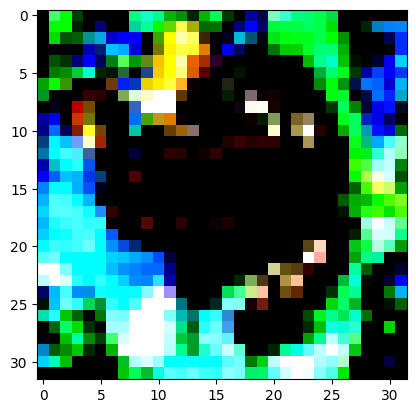

In [7]:
show_image(*train_dataset[200])

In [8]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = 10000
train_size = len(train_dataset) - val_size


In [9]:
# Random Splitting and ensure each class is evenly distributed in teh random split.
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds), len(test_dataset)

(40000, 10000, 10000)

In [10]:
from torch.utils.data import random_split, Subset
torch.manual_seed(10)
def stratified_split(dataset, class_labels, train_percent=0.8, val_percent=0.2):


    # base on the class to classify
    class_to_indices = {c: [] for c in set(class_labels)}
    for idx, label in enumerate(class_labels):
        class_to_indices[label].append(idx)

    train_indices, val_indices = [], []

    # for each class，split according to the rate
    for indices in class_to_indices.values():
        total_count = len(indices)
        train_count = int(total_count * train_percent)
        val_count = int(total_count * val_percent)

        indices = np.random.permutation(indices)
        train_indices.extend(indices[:train_count])
        val_indices.extend(indices[train_count:train_count+val_count])


    return Subset(dataset, train_indices), Subset(dataset, val_indices)



In [11]:
class_labels = train_dataset.targets

train_ds, val_ds = stratified_split(train_dataset, class_labels)
len(train_ds), len(val_ds)

(40000, 10000)

In [12]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [13]:
# def accuracy(output, target, topk=(1,)):
#     """
#     Computes the accuracy over the k top predictions for the specified values of k
#     """
#     with torch.no_grad():
#         maxk = max(topk)  # Get the maximum value in topk
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()

#         correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

#         res = {}
#         for k in topk:
#             correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
#             accuracy_k = correct_k.mul_(100.0 / batch_size)
#             res[k] = accuracy_k.item()  # Store accuracy as a percentage

#         return res  # Return a dictionary of accuracies for each k in topk

# def accuracy(output, target, topk=(1,)):
#     """
#     Computes the accuracy over the k top predictions for the specified values of k
#     In top-3 accuracy you give yourself credit for having the right answer
#     if the right answer appears in your top five guesses.
#     """
#     with torch.no_grad():
#         maxk = 3
#         batch_size = target.size(0)

#         # st()
#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         # st()
#         # correct = pred.eq(target.view(1, -1).expand_as(pred))
#         # correct = (pred == target.view(1, -1).expand_as(pred))
#         correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



#         correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

#         return correct_3.mul_(1.0 / batch_size)


# def accuracy(outputs, labels, topk=(1,)):

#    _, preds = torch.max(outputs, dim=1)
#    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def compute_accuracy(outputs, labels, topk=(1,)):
   _, preds = torch.max(outputs, dim=1)
   return torch.tensor(torch.sum(preds == labels).item() / len(preds))


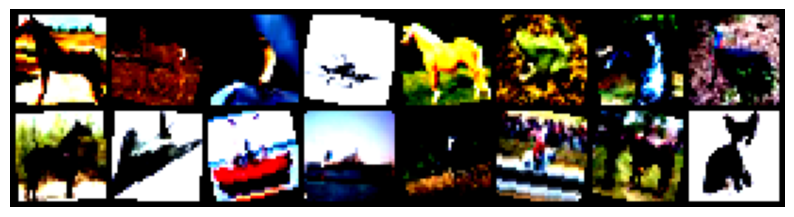

In [14]:
# Multiple images preview.
# Get the first batch of images and labels
images, labels = next(iter(train_loader))
# Select a subset of images to display
images_to_display = images[:16]

# Creating the grid of images
grid = make_grid(images_to_display, nrow=8)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

# 2.0 CNN


## 2.1 Loss function

In [15]:
# # cross_entropy
# class ImageClassificationBase(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels, (5))           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# # Focal Loss
# class ImageClassificationFocalLoss(nn.Module):
#     def __init__(self, alpha=0.5, gamma=2.0):
#         super(ImageClassificationFocalLoss, self).__init__()
#         self.alpha = alpha  # Alpha parameter for Focal Loss
#         self.gamma = gamma  # Gamma parameter for Focal Loss

#     def focal_loss(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()

#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.focal_loss(out, labels)  # Calculate Focal Loss
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.focal_loss(out, labels)  # Calculate Focal Loss
#         acc = accuracy(out, labels, (5))  # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# # Smooth Loss
# class ImageClassificationSmoothLoss(nn.Module):
#     def __init__(self, smooth_factor=0.1):
#         super(ImageClassificationSmoothLoss, self).__init__()
#         self.smooth_factor = smooth_factor  # Smooth factor for Smooth Loss

#     def smooth_loss(self, inputs, targets):
#         num_classes = inputs.size(1)
#         smooth_labels = torch.full_like(inputs, self.smooth_factor / (num_classes - 1))
#         smooth_labels.scatter_(1, targets.unsqueeze(1), 1 - self.smooth_factor)

#         ce_loss = F.kl_div(F.log_softmax(inputs, dim=1), smooth_labels, reduction='batchmean')  # Smooth loss
#         return ce_loss.mean()

#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
#         acc = accuracy(out, labels, (5))  # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))



In [16]:
# cross_entropy
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = compute_accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Focal Loss
class ImageClassificationFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super(ImageClassificationFocalLoss, self).__init__()
        self.alpha = alpha  # Alpha parameter for Focal Loss
        self.gamma = gamma  # Gamma parameter for Focal Loss

    def focal_loss(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.focal_loss(out, labels)  # Calculate Focal Loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.focal_loss(out, labels)  # Calculate Focal Loss
        acc = compute_accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))



# Smooth Loss
class ImageClassificationSmoothLoss(nn.Module):
    def __init__(self, smooth_factor=0.1):
        # super(ImageClassificationSmoothLoss, self).__init__()
        super().__init__()
        self.smooth_factor = smooth_factor  # Smooth factor for Smooth Loss

    def smooth_loss(self, inputs, targets):
        num_classes = inputs.size(1)
        smooth_labels = torch.full_like(inputs, self.smooth_factor / (num_classes - 1))
        smooth_labels.scatter_(1, targets.unsqueeze(1), 1 - self.smooth_factor)

        ce_loss = F.kl_div(F.log_softmax(inputs, dim=1), smooth_labels, reduction='batchmean')  # Smooth loss
        return ce_loss.mean()

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
        acc = compute_accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


## 2.2 Block

In [17]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# class BasicBlock(nn.Module):
#     expansion = 1
#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(BasicBlock, self).__init__()
#         self.conv1 = conv3x3(inplanes, planes)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = nn.LeakyReLU(0.1)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = conv3x3(planes, planes)
#         self.bn3 = nn.BatchNorm2d(planes)
#         self.maxpool = nn.MaxPool2d(stride)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)
#         out += residual
#         out = self.relu(out)
#         out = self.maxpool(out)

#         return out




In [18]:
## Adding Drop
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.LeakyReLU(0.1)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
        self.maxpool = nn.MaxPool2d(stride)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.dropout(out)  # Applying dropout here

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        out = self.maxpool(out)

        return out


## 2.3 resnet12


In [19]:

# Input ->
#     [Conv -> BN -> LeakyReLU -> Conv -> BN -> LeakyReLU -> Conv -> BN -> MaxPool] -> (Layer 1: BasicBlock)
#     [Conv -> BN -> LeakyReLU -> Conv -> BN -> LeakyReLU -> Conv -> BN -> MaxPool] -> (Layer 2: BasicBlock)
#     [Conv -> BN -> LeakyReLU -> Conv -> BN -> LeakyReLU -> Conv -> BN -> MaxPool] -> (Layer 3: BasicBlock)
#     [Conv -> BN -> LeakyReLU -> Conv -> BN -> LeakyReLU -> Conv -> BN -> MaxPool] -> (Layer 4: BasicBlock)
#     AvgPool ->
#     Fully Connected ->
# Output

In [20]:
# class ConvolutionalNetwork(ImageClassificationBase):
#     def __init__(self, block, num_classes=10):
#         self.inplanes = 3
#         super(ConvolutionalNetwork, self).__init__()

#         self.layer1 = self._make_layer(block, 64, stride=2)
#         self.layer2 = self._make_layer(block, 160, stride=2)
#         self.layer3 = self._make_layer(block, 320, stride=2)
#         self.layer4 = self._make_layer(block, 640, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(640 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, planes, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=1, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion

#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = self.layer1(X)

#         x = self.layer2(x)

#         x = self.layer3(x)

#         x = self.layer4(x)


#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         X = self.fc(x)

#         return F.log_softmax(X, dim=1)

# def resnet12_base():
#     return ConvolutionalNetwork(BasicBlock)

# class ConvolutionalNetworkFocalLoss(ImageClassificationFocalLoss):
#     def __init__(self, block, num_classes=10):
#         self.inplanes = 3
#         super(ConvolutionalNetworkFocalLoss, self).__init__()

#         self.layer1 = self._make_layer(block, 64, stride=2)
#         self.layer2 = self._make_layer(block, 160, stride=2)
#         self.layer3 = self._make_layer(block, 320, stride=2)
#         self.layer4 = self._make_layer(block, 640, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(640 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, planes, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=1, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion

#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = self.layer1(X)

#         x = self.layer2(x)

#         x = self.layer3(x)

#         x = self.layer4(x)


#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         X = self.fc(x)

#         return X


# def resnet12_FocalLoss():
#     return ConvolutionalNetworkFocalLoss(BasicBlock)

# class ConvolutionalNetworkSmoothLoss(ImageClassificationSmoothLoss):
#     def __init__(self, block, num_classes=10):
#         self.inplanes = 3
#         super(ConvolutionalNetworkSmoothLoss, self).__init__()

#         self.layer1 = self._make_layer(block, 64, stride=2)
#         self.layer2 = self._make_layer(block, 160, stride=2)
#         self.layer3 = self._make_layer(block, 320, stride=2)
#         self.layer4 = self._make_layer(block, 640, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(640 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, planes, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=1, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion

#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = self.layer1(X)

#         x = self.layer2(x)

#         x = self.layer3(x)

#         x = self.layer4(x)


#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         X = self.fc(x)

#         return X



# def resnet12_SmoothLoss():
#     return ConvolutionalNetworkSmoothLoss(BasicBlock)

In [21]:
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, block, num_classes=10, dropout_probability=0):
        self.inplanes = 3
        super(ConvolutionalNetwork, self).__init__()
        self.dropout = nn.Dropout(dropout_probability)

        self.layer1 = self._make_layer(block, 64, stride=2)
        self.layer2 = self._make_layer(block, 160, stride=2)
        self.layer3 = self._make_layer(block, 320, stride=2, dropout=dropout_probability)  # Adding dropout
        self.layer4 = self._make_layer(block, 640, stride=2, dropout=dropout_probability)  # Adding dropout

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(640 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, stride=1, dropout=0.0):
      downsample = None
      if stride != 1 or self.inplanes != planes * block.expansion:
          downsample = nn.Sequential(
              nn.Conv2d(self.inplanes, planes * block.expansion,
                        kernel_size=1, stride=stride, bias=False),  # Adjusted stride
              nn.BatchNorm2d(planes * block.expansion),
          )

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample, dropout))
      self.inplanes = planes * block.expansion

      return nn.Sequential(*layers)


    def forward(self, X):
        x = self.layer1(X)

        x = self.layer2(x)

        x = self.layer3(x)
        x = self.dropout(x)  # Applying dropout
        x = self.layer4(x)
        x = self.dropout(x)  # Applying dropout

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        X = self.fc(x)

        return F.log_softmax(X, dim=1)

def resnet12_base(dropout_pro):
    return ConvolutionalNetwork(BasicBlock, num_classes=10, dropout_probability=dropout_pro)


class ConvolutionalNetworkFocalLoss(ImageClassificationFocalLoss):
    def __init__(self, block, num_classes=10, dropout_probability=0):
        self.inplanes = 3
        super(ConvolutionalNetworkFocalLoss, self).__init__()
        self.dropout = nn.Dropout(dropout_probability)

        self.layer1 = self._make_layer(block, 64, stride=2)
        self.layer2 = self._make_layer(block, 160, stride=2)
        self.layer3 = self._make_layer(block, 320, stride=2, dropout=dropout_probability)
        self.layer4 = self._make_layer(block, 640, stride=2, dropout=dropout_probability)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(640 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, X):
        x = self.layer1(X)

        x = self.layer2(x)

        x = self.layer3(x)
        x = self.dropout(x)  # Applying dropout
        x = self.layer4(x)
        x = self.dropout(x)  # Applying dropout

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        X = self.fc(x)

        return X


def resnet12_FocalLoss(dropout_pro):
    return ConvolutionalNetworkFocalLoss(BasicBlock, num_classes=10, dropout_probability=dropout_pro)




class ConvolutionalNetworkSmoothLoss(ImageClassificationSmoothLoss):
    def __init__(self, block, num_classes=10, dropout_probability = 0 ):
        super().__init__()
        # super(ConvolutionalNetworkSmoothLoss, self).__init__()
        self.inplanes = 3
        self.dropout = nn.Dropout(dropout_probability)
        self.layer1 = self._make_layer(block, 64, stride=2)
        self.layer2 = self._make_layer(block, 160, stride=2)
        self.layer3 = self._make_layer(block, 320, stride=2)
        self.layer4 = self._make_layer(block, 640, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(640 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, X):
        x = self.layer1(X)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)


        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        X = self.fc(x)

        return X



def resnet12_SmoothLoss(dropout_pro):
    return ConvolutionalNetworkSmoothLoss(BasicBlock, num_classes=10, dropout_probability=dropout_pro)

# 3.0 Funcitons


In [22]:
# To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## 3.1 Training funtion

In [23]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
device

device(type='cuda')

In [24]:
input_size = 3*32*32
output_size = 10

In [25]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

lr_gamma = 0.1
def fit(epochs, lr, model, train_loader, val_loader, optimizer_class=torch.optim.SGD, patience=7, l2=0.005):
    history = []
    if optimizer_class == torch.optim.Adam:
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=l2)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=0.9, weight_decay=l2)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=lr_gamma)

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        lr_scheduler.step()
        history.append(result)

        # Check for early stopping
        val_loss = result['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history

In [26]:
def train_with_hyperparameters(loss_function, learning_rate, num_epochs, batch_size, dropout, optimizer_type, l2_weight=0.005):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create the model with the specified dropout rate


    if loss_function == 'cross_entropy':
        model = resnet12_base(dropout).to(device)

    elif loss_function == 'focal_loss':
        model = resnet12_FocalLoss(dropout).to(device)


    elif loss_function == 'smooth_loss':
        model = resnet12_SmoothLoss(dropout).to(device)

    else:
        raise ValueError("Invalid loss function. Use 'cross_entropy', 'focal_loss', or 'smooth_loss'.")

    # Define the optimizer based on the optimizer_type parameter
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_type == 'RMSprop':
        optimizer = torch.optim.RMSprop

    else:
        raise ValueError("Invalid optimizer type. Use 'SGD' or 'Adam' or 'RMSprop'.")


    # Create DataLoader objects with the specified batch size and move data to GPU
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

    device = get_default_device()
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)

    # Train the model with the specified number of epochs
    # history = fit(num_epochs, learning_rate, model, train_loader, val_loader, optimizer)
    history = [evaluate(model, val_loader)]
    history += fit(num_epochs, learning_rate, model, train_loader, val_loader, optimizer, patience=5, l2=l2_weight)

    # Evaluate the model on the test set
    result = evaluate(model, test_loader)
    print(result)

    # Return the model and history
    return model, history

In [27]:
# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now, device will hold the correct device based on the availability of GPU
print("Selected device:", device)

Selected device: cuda


## 3.2 get results function

In [28]:
# def get_best_combination(results):
#     last_accuracy = 0.0
#     last_epoch_combination = None

#     for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
#         # Get the accuracy from the last epoch in the history
#         last_epoch_result = history[-1]  # Assuming that the last epoch's result is at the end of the history list
#         val_accuracy = last_epoch_result['val_acc']

#         # Check if the last epoch's accuracy is higher than the current highest accuracy
#         if val_accuracy > last_accuracy:
#             last_accuracy = val_accuracy
#             last_epoch_combination = (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, l2_weight)

#     return last_epoch_combination, last_accuracy


import heapq

def get_best_combinations(results, k):
    best_combinations = []

    # Sorting all the results based on the validation accuracy in descending order
    sorted_results = sorted(results, key=lambda x: x[-2][-1]['val_acc'], reverse=True)

    # Getting the top k results
    for i in range(min(k, len(sorted_results))):
        lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight = sorted_results[i]
        val_accuracy = history[-1]['val_acc']  # Getting the validation accuracy from the last epoch
        best_combinations.append(((lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, l2_weight), val_accuracy))

    return best_combinations



In [29]:
def get_combinations(results, k):
    best_combinations = []

    # Sorting all the results based on the validation accuracy in descending order
    sorted_results = sorted(results, key=lambda x: x[-2][-1]['val_acc'], reverse=True)

    # Getting the top k results
    for i in range(min(k, len(sorted_results))):
        lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight = sorted_results[i]
        val_accuracy = history[-1]['val_acc']  # Getting the validation accuracy from the last epoch
        combination = (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight)
        best_combinations.append(combination)

    return best_combinations


In [30]:
def list_combinations(results):
    for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
        print(f"Combination {i+1}:")
        print(f"Learning Rate: {lr}")
        print(f"Number of Epochs: {num_epochs}")
        print(f"Batch Size: {batch_size}")
        print(f"Dropout Rate: {dropout}")
        print(f"Optimizer Type: {optimizer_type}")
        print(f"Loss Function: {loss_function}")
        print(f"L2 Weight: {l2_weight}")



        # Get the final accuracy and loss from the history
        final_accuracy = history[-1]['val_acc']
        final_loss = history[-1]['val_loss']

        print(f"Final Validation Accuracy: {final_accuracy:.2f}")
        print(f"Final Validation Loss: {final_loss:.4f}")
        print("-----------------------------------------------------")



In [31]:
def plot_losses(results):
    markers = ['x', 'o', 's', '^', 'v', 'D', 'p']
    for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
        train_losses = [x.get('train_loss') for x in history]
        val_losses = [x['val_loss'] for x in history]
        color = plt.cm.jet(float(i) / len(results))  # Assign different colors based on a colormap
        marker = markers[i % len(markers)]  # Cycle through marker styles for each combination
        plt.plot(train_losses, color=color, marker=marker, label=f"Combination {i+1}: lr={lr}, dropout={dropout}, optimizer={optimizer_type}, loss={loss_function} - Training Loss")
        plt.plot(val_losses, color=color, marker=marker, linestyle='dashed', label=f"Combination {i+1}: lr={lr}, dropout={dropout}, optimizer={optimizer_type}, loss={loss_function} - Validation Loss")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)  # Place legend at the bottom center and in two columns
    plt.rcParams["figure.figsize"] = (10, 7)  # Set figure size
    plt.show()

In [32]:
def plot_accuracies(results):
    plt.figure(figsize=(12, 7))
    for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
        accuracies = [x['val_acc'] for x in history]
        plt.plot(accuracies, '-x', label=f"Model {i+1}: LR={lr}, Epochs={num_epochs}, Batch size={batch_size}, Dropout={dropout}, Optimizer={optimizer_type}, Loss={loss_function}")

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Epochs for Different Models')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Place legend at the bottom center and in two columns
    plt.grid(True)
    plt.show()



# 4.0 Train
Params: (0.001, 50, 32, 0, 'Adam', 'smooth_loss', 0), Accuracy: 0.9133386611938477

In [33]:
lr = 0.001
num_epochs = 50
batch_size = 32
l2_weight = 0
dropout = 0
optimizer_type = 'Adam'
loss_function = 'smooth_loss'
# loss_functions = ['cross_entropy', 'focal_loss', 'smooth_loss']
# 'SGD', 'Adam', 'RMSprop'
# Initialize a list to store the results
results1 = []
num_classes = 10
lr_gamma = 0.1
model, history = train_with_hyperparameters(loss_function, lr, num_epochs, batch_size, dropout, optimizer_type, l2_weight)
results1.append((lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight))

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.0039, val_loss: 0.8461, val_acc: 0.6195


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6959, val_loss: 0.6393, val_acc: 0.7153


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5797, val_loss: 0.5356, val_acc: 0.7705


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5028, val_loss: 0.5302, val_acc: 0.7749


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.4461, val_loss: 0.4450, val_acc: 0.8089


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4013, val_loss: 0.4197, val_acc: 0.8223


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3624, val_loss: 0.3907, val_acc: 0.8370


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3274, val_loss: 0.3911, val_acc: 0.8326


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.3015, val_loss: 0.3485, val_acc: 0.8541


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.2721, val_loss: 0.3425, val_acc: 0.8529


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.2496, val_loss: 0.3348, val_acc: 0.8572


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.2267, val_loss: 0.3105, val_acc: 0.8663


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.2071, val_loss: 0.2877, val_acc: 0.8762


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1906, val_loss: 0.2954, val_acc: 0.8730


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1771, val_loss: 0.2873, val_acc: 0.8787


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.1641, val_loss: 0.3059, val_acc: 0.8715


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.1520, val_loss: 0.2959, val_acc: 0.8727


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1399, val_loss: 0.2701, val_acc: 0.8843


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1306, val_loss: 0.2951, val_acc: 0.8780


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1210, val_loss: 0.2758, val_acc: 0.8810


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.1134, val_loss: 0.2689, val_acc: 0.8897


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1057, val_loss: 0.2757, val_acc: 0.8864


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1002, val_loss: 0.2832, val_acc: 0.8797


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0977, val_loss: 0.2895, val_acc: 0.8827


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0894, val_loss: 0.2762, val_acc: 0.8866


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0837, val_loss: 0.2527, val_acc: 0.8956


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0785, val_loss: 0.2703, val_acc: 0.8890


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0773, val_loss: 0.2641, val_acc: 0.8906


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0718, val_loss: 0.2809, val_acc: 0.8868


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0684, val_loss: 0.2750, val_acc: 0.8871


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0424, val_loss: 0.2199, val_acc: 0.9074


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0323, val_loss: 0.2215, val_acc: 0.9068


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0293, val_loss: 0.2179, val_acc: 0.9060


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0256, val_loss: 0.2231, val_acc: 0.9054


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0239, val_loss: 0.2133, val_acc: 0.9085


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0226, val_loss: 0.2164, val_acc: 0.9072


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0214, val_loss: 0.2142, val_acc: 0.9092


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0204, val_loss: 0.2115, val_acc: 0.9120


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0194, val_loss: 0.2130, val_acc: 0.9101


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0183, val_loss: 0.2139, val_acc: 0.9112


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0172, val_loss: 0.2079, val_acc: 0.9157


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0172, val_loss: 0.2127, val_acc: 0.9120


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0166, val_loss: 0.2081, val_acc: 0.9126


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0161, val_loss: 0.2064, val_acc: 0.9137


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0157, val_loss: 0.2115, val_acc: 0.9119


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0152, val_loss: 0.2060, val_acc: 0.9128


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0153, val_loss: 0.2068, val_acc: 0.9159


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0151, val_loss: 0.2089, val_acc: 0.9132


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0150, val_loss: 0.2141, val_acc: 0.9103


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0148, val_loss: 0.2053, val_acc: 0.9138
{'val_loss': 0.18941283226013184, 'val_acc': 0.9231230020523071}


In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

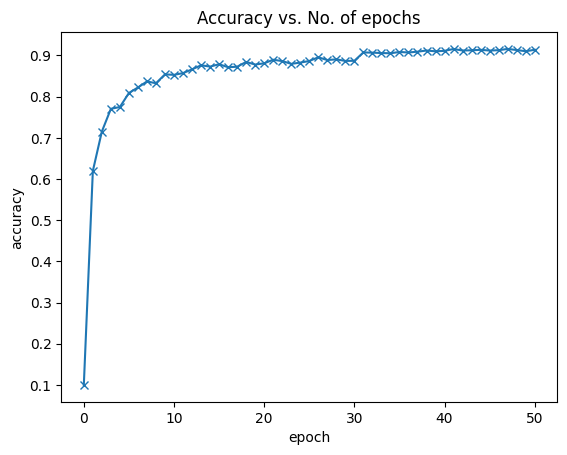

In [36]:
plot_accuracies(history)

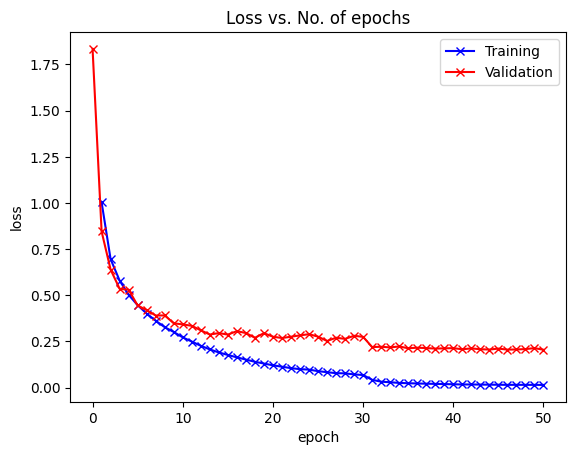

In [37]:
plot_losses(history)

In [38]:
print("Test accuracy:")
evaluate(model, test_loader)

Test accuracy:


{'val_loss': 0.18944478034973145, 'val_acc': 0.9231687784194946}

# Flop

In [38]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2023-10-24 01:51:46--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=jrmp2j8msnb43g9vlbh7l6os3q; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=D0Ke0jfRTkmOkUX%2BZyzO%2FXcuqk7akyd%2Bsm4DlDTF702abzjH9B6q58TVOq5P5DMlJ88gKn5U0kPOHO0u8JnHSv8o9mlNmCRXz6AGZc1dyxFB%2FInjo2ZyOPVp0Tt%2Be%2FUI; expires=Wed, 25-Oct-2023 01:51:47 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 228.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-10-24 01:51:48 (1.37 GB/s) - ‘download’ saved [5201/5201]



In [39]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(32, 3, 32, 32) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 10
model = resnet12_SmoothLoss(0)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 1.05G
